#Descripcion del proyecto

Trabajas en una empresa emergente que vende productos alimenticios. Debes investigar el comportamiento del usuario para la aplicación de la empresa.

Primero, estudia el embudo de ventas. Descubre cómo los usuarios llegan a la etapa de compra. ¿Cuántos usuarios realmente llegan a esta etapa? ¿Cuántos se atascan en etapas anteriores? ¿Qué etapas en particular?

Luego, observa los resultados de un test A/A/B (sigue leyendo para obtener más información sobre los test A/A/B). Al equipo de diseño le gustaría cambiar las fuentes de toda la aplicación, pero la gerencia teme que los usuarios piensen que el nuevo diseño es intimidante. Por ello, deciden tomar una decisión basada en los resultados de un test A/A/B.

Los usuarios se dividen en tres grupos: dos grupos de control obtienen las fuentes antiguas y un grupo de prueba obtiene las nuevas. Descubre qué conjunto de fuentes produce mejores resultados.

Crear dos grupos A tiene ciertas ventajas. Podemos establecer el principio de que solo confiaremos en la exactitud de nuestras pruebas cuando los dos grupos de control sean similares. Si hay diferencias significativas entre los grupos A, esto puede ayudarnos a descubrir factores que pueden estar distorsionando los resultados. La comparación de grupos de control también nos dice cuánto tiempo y datos necesitaremos cuando realicemos más tests.

Utilizarás el mismo dataset para el análisis general y para el análisis A/A/B. En proyectos reales, los experimentos se llevan a cabo constantemente. El equipo de análisis estudia la calidad de una aplicación utilizando datos generales, sin prestar atención a si los usuarios participan en experimentos.

#Preprocesamiento, analisis, correccion, limpieza y enriquecimiento de datos

In [ ]:
#importamos todas las librerias con las cuales vamos a trabajar
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
import re
from scipy.stats import mannwhitneyu
from statsmodels.stats.proportion import proportions_ztest

In [ ]:
#cargamos el dataset y lo leemos para conocer los datos con los cuales vamos a trabajar
logs = pd.read_csv('/content/logs_exp_us.csv', sep='\t')
logs.head()

,EventName,DeviceIDHash,EventTimestamp,ExpId
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248


In [ ]:
#cambiamos los nombres de nuestras columnas para resolver cualquier problema con
# los encabezados con el fin de preservar las reglas del buen estilo
logs.rename(columns={
    'EventName': 'event_name',
    'DeviceIDHash': 'device_id_hash',
    'EventTimestamp': 'event_timestamp',
    'ExpId': 'exp_id'
}, inplace=True)

In [ ]:
#visulizamos la informacion de nuestros datos
print(logs.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   event_name       244126 non-null  object
 1   device_id_hash   244126 non-null  int64 
 2   event_timestamp  244126 non-null  int64 
 3   exp_id           244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB
None


In [ ]:
#corregimos los tipos de columnas necesarias para futuros calculos
logs['event_timestamp']=pd.to_datetime(logs['event_timestamp'],unit='s')

logs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   event_name       244126 non-null  object        
 1   device_id_hash   244126 non-null  int64         
 2   event_timestamp  244126 non-null  datetime64[ns]
 3   exp_id           244126 non-null  int64         
dtypes: datetime64[ns](1), int64(2), object(1)
memory usage: 7.5+ MB


In [ ]:
#revisamos valures ausentes en nuestros datos
logs.isnull().count()

,0
event_name,244126
device_id_hash,244126
event_timestamp,244126
exp_id,244126


In [ ]:
#C
logs.duplicated().sum()

np.int64(413)

In [ ]:
#eliminamos valores duplicados para evitar errores en nuestros calculos
logs=logs.drop_duplicates()
logs.info()

<class 'pandas.core.frame.DataFrame'>
Index: 243713 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   event_name       243713 non-null  object        
 1   device_id_hash   243713 non-null  int64         
 2   event_timestamp  243713 non-null  datetime64[ns]
 3   exp_id           243713 non-null  int64         
dtypes: datetime64[ns](1), int64(2), object(1)
memory usage: 9.3+ MB


In [ ]:
#revisamos que no existan device_id_hash en mas de un grupo de experimento
# Agrupar por 'device_id_hash' y contar cuántos 'exp_id' únicos tiene cada uno
exp_por_dispositivo = logs.groupby('device_id_hash')['exp_id'].nunique()

# Filtrar los dispositivos que tienen más de un 'exp_id'
dispositivos_en_mas_de_un_exp = exp_por_dispositivo[exp_por_dispositivo > 1].count()

print(f"Cantidad de device_id_hash en más de un exp_id: {dispositivos_en_mas_de_un_exp}")


Cantidad de device_id_hash en más de un exp_id: 0


In [ ]:
#Agregamos una nueva columna con fecha y hora
logs['date_time']= logs['event_timestamp']

<ipython-input-268-8c2481ecb851>:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
#Agregamos una columna nueva unicamente con la fecha de nuestros datos
logs['date'] = logs['event_timestamp'].dt.date
logs.head()

,event_name,device_id_hash,event_timestamp,exp_id,date_time,date
0,MainScreenAppear,4575588528974610257,2019-07-25 04:43:36,246,2019-07-25 04:43:36,2019-07-25
1,MainScreenAppear,7416695313311560658,2019-07-25 11:11:42,246,2019-07-25 11:11:42,2019-07-25
2,PaymentScreenSuccessful,3518123091307005509,2019-07-25 11:28:47,248,2019-07-25 11:28:47,2019-07-25
3,CartScreenAppear,3518123091307005509,2019-07-25 11:28:47,248,2019-07-25 11:28:47,2019-07-25
4,PaymentScreenSuccessful,6217807653094995999,2019-07-25 11:48:42,248,2019-07-25 11:48:42,2019-07-25


#Paso 1 estudiar y comprobar los datos

1.1.-¿Cuántos eventos hay en los registros?

In [ ]:
numero_eventos = logs.shape[0]

print(f"Número de eventos en los registros: {numero_eventos}")

Número de eventos en los registros: 243713


1.2.-¿Cuántos usuarios hay en los registros?

In [ ]:
numero_usuarios = logs['device_id_hash'].nunique()

print(f"Número de usuarios únicos en los registros: {numero_usuarios}")

Número de usuarios únicos en los registros: 7551


1.3.-¿Cuál es el promedio de eventos por usuario?

In [ ]:
promedio_eventos_por_usuario = numero_eventos / numero_usuarios

print(f"Promedio de eventos por usuario: {promedio_eventos_por_usuario:.2f}")

Promedio de eventos por usuario: 32.28


1.4.-¿Qué periodo de tiempo cubren los datos?

Encuentra la fecha máxima y mínima.

Traza un histograma por fecha y hora.

¿Puedes tener seguridad de que tienes datos igualmente completos para todo el periodo? Los eventos más antiguos podrían terminar en los registros de algunos usuarios por razones técnicas y esto podría sesgar el panorama general.

Encuentra el momento en el que los datos comienzan a estar completos e ignora la sección anterior.

¿Qué periodo representan realmente los datos?

In [ ]:
#encontramos la fecha minima y la maxima
#fecha mínima
fecha_minima = logs['date'].min()

#fecha máxima
fecha_maxima = logs['date'].max()

print(f"Fecha mínima: {fecha_minima}")
print(f"Fecha máxima: {fecha_maxima}")

Fecha mínima: 2019-07-25
Fecha máxima: 2019-08-07


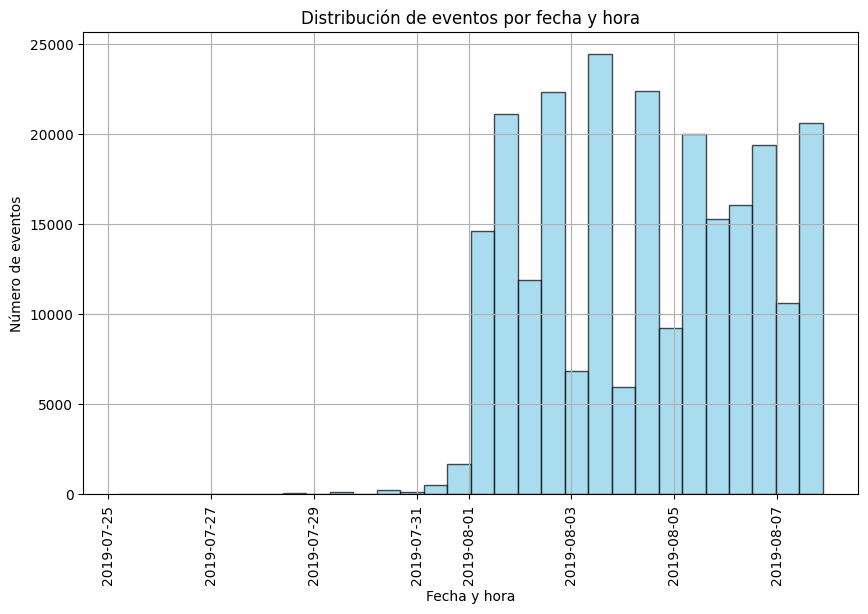

In [ ]:
# Creamos el histograma
plt.figure(figsize=(10, 6))
plt.hist(logs['date_time'], bins=30, color='skyblue', edgecolor='black', alpha=0.7)

# Personalizamos el gráfico
plt.xlabel('Fecha y hora')
plt.ylabel('Número de eventos')
plt.title('Distribución de eventos por fecha y hora')
plt.grid(True)
plt.xticks(rotation=90)

plt.show()

***Despues de analizar los resultados y el grafico decidimos tomar en cuenta unicamente los datos que se empiezan reflejar a partir de 2019-08-01 que es donde empiezan a estar completos***

In [ ]:
#filtramos nuestros datos para trabajar con los que concideramos completos
logs['date']= pd.to_datetime(logs['date'])
logs_filtrado= logs[logs['date']>= '2019-08-01']
logs_filtrado


,event_name,device_id_hash,event_timestamp,exp_id,date_time,date
2828,Tutorial,3737462046622621720,2019-08-01 00:07:28,246,2019-08-01 00:07:28,2019-08-01
2829,MainScreenAppear,3737462046622621720,2019-08-01 00:08:00,246,2019-08-01 00:08:00,2019-08-01
2830,MainScreenAppear,3737462046622621720,2019-08-01 00:08:55,246,2019-08-01 00:08:55,2019-08-01
2831,OffersScreenAppear,3737462046622621720,2019-08-01 00:08:58,246,2019-08-01 00:08:58,2019-08-01
2832,MainScreenAppear,1433840883824088890,2019-08-01 00:08:59,247,2019-08-01 00:08:59,2019-08-01
...,...,...,...,...,...,...
244121,MainScreenAppear,4599628364049201812,2019-08-07 21:12:25,247,2019-08-07 21:12:25,2019-08-07
244122,MainScreenAppear,5849806612437486590,2019-08-07 21:13:59,246,2019-08-07 21:13:59,2019-08-07
244123,MainScreenAppear,5746969938801999050,2019-08-07 21:14:43,246,2019-08-07 21:14:43,2019-08-07
244124,MainScreenAppear,5746969938801999050,2019-08-07 21:14:58,246,2019-08-07 21:14:58,2019-08-07


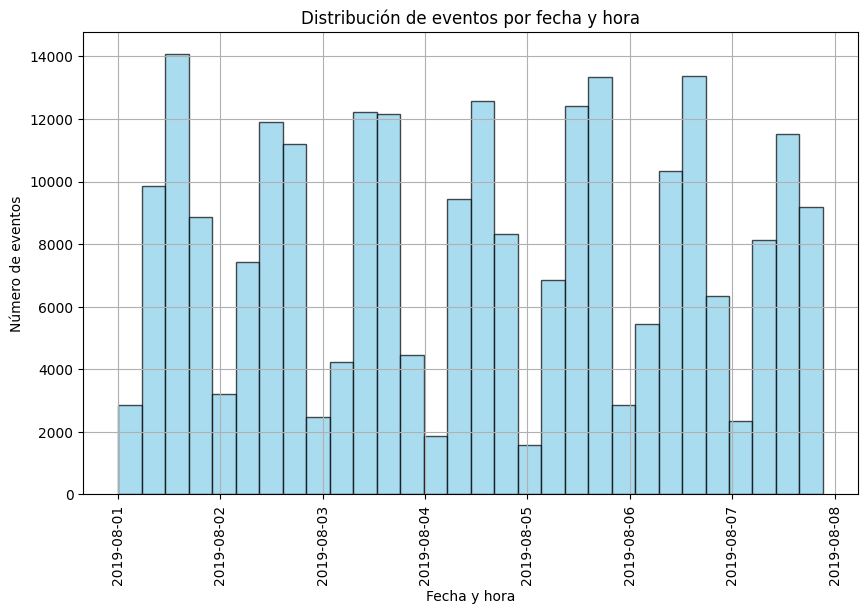

In [ ]:
# Creamos el histograma
plt.figure(figsize=(10, 6))
plt.hist(logs_filtrado['date_time'], bins=30, color='skyblue', edgecolor='black', alpha=0.7)

# Personalizamos el gráfico
plt.xlabel('Fecha y hora')
plt.ylabel('Número de eventos')
plt.title('Distribución de eventos por fecha y hora')
plt.grid(True)
plt.xticks(rotation=90)

plt.show()

1.5.-¿Qué periodo representan realmente los datos?

In [ ]:
logs_filtrado['date']=pd.to_datetime(logs_filtrado['date']).dt.date
#fecha mínima
fecha_minima = logs_filtrado['date'].min()

#fecha máxima
fecha_maxima = logs_filtrado['date'].max()

print(f"Fecha mínima: {fecha_minima}")
print(f"Fecha máxima: {fecha_maxima}")

Fecha mínima: 2019-08-01
Fecha máxima: 2019-08-07


<ipython-input-277-3e26b737dff4>:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



1.6.-¿Perdiste muchos eventos y usuarios al excluir los datos más antiguos?

In [ ]:
#Calculamos el numero y porcentaje de eventos perdidos despues de haber filtrado nuestros datos
numero_eventos_filtrado = logs_filtrado.shape[0]

print(f"Número de eventos perdidos al filtrar los datos es de : {numero_eventos-numero_eventos_filtrado}")
print(f"El porcentaje de eventos perdidos al filtrar los datos es de : {(numero_eventos-numero_eventos_filtrado)*100/numero_eventos:.2f}%")

#Calculamos el numero y porcentaje de usuaros perdidos despues de haber filtrado nuestros datos
numero_usuarios_filtrado = logs_filtrado['device_id_hash'].nunique()

print(f"Número de usuarios únicos perdidos al filtrar los datos es de : {numero_usuarios-numero_usuarios_filtrado}")
print(f"El porcentaje de usuarios perdidos al filtrar los datos es de : {(numero_usuarios-numero_usuarios_filtrado)*100/numero_usuarios:.2f}% ")

Número de eventos perdidos al filtrar los datos es de : 2826
El porcentaje de eventos perdidos al filtrar los datos es de : 1.16%
Número de usuarios únicos perdidos al filtrar los datos es de : 17
El porcentaje de usuarios perdidos al filtrar los datos es de : 0.23% 


1.7.-Asegúrate de tener usuarios de los tres grupos experimentales.

In [ ]:
# Contamos cuántos usuarios únicos hay en cada grupo experimental
usuarios_por_grupo = logs_filtrado.groupby('exp_id')['device_id_hash'].nunique()

print("Número de usuarios únicos por grupo experimental:")
usuarios_por_grupo.reset_index()

Número de usuarios únicos por grupo experimental:


,exp_id,device_id_hash
0,246,2484
1,247,2513
2,248,2537


#Paso 2. Estudiar el embudo de eventos

2.1.-Observa qué eventos hay en los registros y su frecuencia de suceso. Ordénalos por frecuencia

In [ ]:
# Contamos la frecuencia de cada evento y ordenamos en orden descendente
frecuencia_eventos = logs_filtrado['event_name'].value_counts()

print("Frecuencia de eventos:")
frecuencia_eventos.reset_index()


Frecuencia de eventos:


,event_name,count
0,MainScreenAppear,117328
1,OffersScreenAppear,46333
2,CartScreenAppear,42303
3,PaymentScreenSuccessful,33918
4,Tutorial,1005


2.2.-Encuentra la cantidad de usuarios que realizaron cada una de estas acciones.

Ordena los eventos por el número de usuarios.

Calcula la proporción de usuarios que realizaron la acción al menos una vez

In [ ]:
# Contamos los usuarios únicos por evento
usuarios_por_evento = logs_filtrado.groupby('event_name')['device_id_hash'].nunique().reset_index()
usuarios_por_evento.columns = ['event_name', 'usuarios_unicos']
# Ordenamos los eventos por el número de usuarios únicos
usuarios_por_evento = usuarios_por_evento.sort_values(by='usuarios_unicos', ascending=False)
# Calculamos la proporción de usuarios que realizaron cada acción al menos una vez
total_usuarios = logs_filtrado['device_id_hash'].nunique()
usuarios_por_evento['proporcion'] = usuarios_por_evento['usuarios_unicos'] / total_usuarios

usuarios_por_evento




,event_name,usuarios_unicos,proporcion
1,MainScreenAppear,7419,0.984736
2,OffersScreenAppear,4593,0.609636
0,CartScreenAppear,3734,0.495620
3,PaymentScreenSuccessful,3539,0.469737
4,Tutorial,840,0.111495


2.3.-¿En qué orden crees que ocurrieron las acciones? ¿Todas son parte de una sola secuencia? No es necesario tenerlas en cuenta al calcular el embudo.

***El orden natural sigue el comportamiento de los usuarios a través del embudo. Los pasos más amplios MainScreenAppear representan la entrada de usuarios, mientras que los pasos más estrechos PaymentScreenSuccessful reflejan las conversiones.***

***Los pasos intermedios OffersScreenAppear y CartScreenAppear muestran puntos críticos donde ocurre mayor pérdida de usuarios.***

***Tutorial tiene un 11.15% de participacion, este evento tiene una participación extremadamente baja y no parece formar parte del flujo principal. Su baja proporción indica que la mayoría de los usuarios no interactúan con el tutorial.***

2.4.-Utiliza el embudo de eventos para encontrar la proporción de usuarios que pasan de una etapa a la siguiente. Por ejemplo, para la secuencia de eventos A → B → C, calcula la proporción de usuarios en la etapa B a la cantidad de usuarios en la etapa A y la proporción de usuarios en la etapa C a la cantidad en la etapa B.

In [ ]:
# Usuarios únicos en cada etapa del embudo
usuarios_A = logs_filtrado[logs_filtrado['event_name'] == 'MainScreenAppear']['device_id_hash'].nunique()
usuarios_B = logs_filtrado[logs_filtrado['event_name'] == 'OffersScreenAppear']['device_id_hash'].nunique()
usuarios_C = logs_filtrado[logs_filtrado['event_name'] == 'CartScreenAppear']['device_id_hash'].nunique()
usuarios_D = logs_filtrado[logs_filtrado['event_name'] == 'PaymentScreenSuccessful']['device_id_hash'].nunique()

# Calculamos las proporciones entre etapas
proporcion_A_B = usuarios_B / usuarios_A
proporcion_B_C = usuarios_C / usuarios_B
proporcion_C_D = usuarios_D / usuarios_C

#resultados
print(f"Proporción de usuarios que pasan de MainScreenAppear → OffersScreenAppear: {proporcion_A_B:.2f}")
print(f"Proporción de usuarios que pasan de OffersScreenAppear → CartScreenAppear: {proporcion_B_C:.2f}")
print(f"Proporción de usuarios que pasan de CartScreenAppear → PaymentScreenSuccessful: {proporcion_C_D:.2f}")


Proporción de usuarios que pasan de MainScreenAppear → OffersScreenAppear: 0.62
Proporción de usuarios que pasan de OffersScreenAppear → CartScreenAppear: 0.81
Proporción de usuarios que pasan de CartScreenAppear → PaymentScreenSuccessful: 0.95


2.5.-¿En qué etapa pierdes más usuarios?

In [ ]:
# Calculamos la pérdida de usuarios en cada transición
perdida_A_B = usuarios_A - usuarios_B
perdida_B_C = usuarios_B - usuarios_C
perdida_C_D = usuarios_C - usuarios_D

#resultados
print(f"Pérdida de usuarios de MainScreenAppear → OffersScreenAppear: {perdida_A_B}")
print(f"Pérdida de usuarios de OffersScreenAppear → CartScreenAppear: {perdida_B_C}")
print(f"Pérdida de usuarios de CartScreenAppear → PaymentScreenSuccessful: {perdida_C_D}")


Pérdida de usuarios de MainScreenAppear → OffersScreenAppear: 2826
Pérdida de usuarios de OffersScreenAppear → CartScreenAppear: 859
Pérdida de usuarios de CartScreenAppear → PaymentScreenSuccessful: 195


In [ ]:
import plotly.graph_objects as go

# Ejemplo: datos del embudo
etapas = ['MainScreenAppear', 'OffersScreenAppear', 'CartScreenAppear', 'PaymentScreenSuccessful']
usuarios = [
    logs_filtrado[logs_filtrado['event_name'] == 'MainScreenAppear']['device_id_hash'].nunique(),
    logs_filtrado[logs_filtrado['event_name'] == 'OffersScreenAppear']['device_id_hash'].nunique(),
    logs_filtrado[logs_filtrado['event_name'] == 'CartScreenAppear']['device_id_hash'].nunique(),
    logs_filtrado[logs_filtrado['event_name'] == 'PaymentScreenSuccessful']['device_id_hash'].nunique()
]

# Cálculo de pérdidas entre etapas
perdidas = [0]  # Inicialmente, no hay pérdida en la primera etapa
for i in range(1, len(usuarios)):
    perdidas.append(usuarios[i - 1] - usuarios[i])  # Diferencia entre etapas consecutivas

# Crear el gráfico de funnel con pérdidas
fig = go.Figure(go.Funnel(
    y=etapas,
    x=usuarios,
    textinfo="value+percent initial+percent previous",  # Incluye porcentaje respecto a la etapa inicial y anterior
    texttemplate="<b>%{label}</b><br>Usuarios: %{value}<br>Pérdidas: %{text}",  # Personalización del texto
    text=perdidas  # Agregar las pérdidas calculadas
))

# Títulos del gráfico
fig.update_layout(
    title="Embudo de Conversión de Usuarios con Pérdidas",
    xaxis_title="Usuarios Únicos",
    yaxis_title="Etapas del Embudo"
)

# Mostrar el gráfico
fig.show()


2.6.-¿Qué porcentaje de usuarios hace todo el viaje desde su primer evento hasta el pago?

In [ ]:
# calculamos los suarios únicos en la primera etapa (inicio del embudo)
usuarios_inicio = logs_filtrado[logs_filtrado['event_name'] == 'MainScreenAppear']['device_id_hash'].nunique()

# calculamos los usuarios únicos en la última etapa (pago)
usuarios_pago = logs_filtrado[logs_filtrado['event_name'] == 'PaymentScreenSuccessful']['device_id_hash'].nunique()

# Calculamos el porcentaje de usuarios que completan el embudo
porcentaje_completan = (usuarios_pago / usuarios_inicio) * 100
print(f"Porcentaje de usuarios que hacen todo el viaje desde su primer evento hasta el pago: {porcentaje_completan:.2f}%")


Porcentaje de usuarios que hacen todo el viaje desde su primer evento hasta el pago: 47.70%


#Pasos 3.- Estudiar los resultados del experimento

3.1.-¿Cuántos usuarios hay en cada grupo?

In [ ]:
# Contamos los usuarios únicos por grupo (exp_id)
usuarios_por_grupo = logs_filtrado.groupby('exp_id')['device_id_hash'].nunique()
usuarios_por_grupo.reset_index()


,exp_id,device_id_hash
0,246,2484
1,247,2513
2,248,2537


3.2.-Tenemos dos grupos de control en el test A/A, donde comprobamos nuestros mecanismos y cálculos. Observa si hay una diferencia estadísticamente significativa entre las muestras 246 y 247.

In [ ]:
# Filtramos los datos de los grupos
grupo_246 = logs_filtrado[logs_filtrado['exp_id'] == 246]['device_id_hash']
grupo_247 = logs_filtrado[logs_filtrado['exp_id'] == 247]['device_id_hash']

# Realizamos la Prueba U de Mann-Whitney
u_stat, p_value = mannwhitneyu(grupo_246, grupo_247)

# Mostramos los resultados
print(f"Prueba U de Mann-Whitney: Estadístico={u_stat}, p-valor={p_value}")

# Interpretación de los resultados
if p_value < 0.05:
    print("Hay una diferencia estadísticamente significativa entre las muestras 246 y 247.")
else:
    print("No hay una diferencia estadísticamente significativa entre las muestras 246 y 247.")


Prueba U de Mann-Whitney: Estadístico=2960960778.0, p-valor=1.805814749631953e-25
Hay una diferencia estadísticamente significativa entre las muestras 246 y 247.


***La hipótesis nula en esta prueba es que las distribuciones de ambos grupos son iguales. Dado el p-valor tan pequeño, es muy probable que las distribuciones no sean iguales. Esto implica que existe una diferencia estadística significativa entre los dos grupos***

3.3.-Selecciona el evento más popular.

En cada uno de los grupos de control, encuentra la cantidad de usuarios que realizaron esta acción.

Encuentra su proporción.

Comprueba si la diferencia entre los grupos es estadísticamente significativa.

Repite el procedimiento para todos los demás eventos (ahorrarás tiempo si creas una función especial para esta prueba).

¿Puedes confirmar que los grupos se dividieron correctamente?

In [ ]:
import pandas as pd


group_246 = logs_filtrado.query('exp_id == 246')
group_247 = logs_filtrado.query('exp_id == 247')
group_248 = logs_filtrado.query('exp_id == 248')
group_246_247 = logs_filtrado.query('exp_id in [246, 247]')


# Función para realizar el z-test de proporciones
def ztest_proporciones(df1, df2, event_name):
    # Obtener usuarios únicos en cada grupo
    usuarios_df1 = df1['device_id_hash'].drop_duplicates()
    usuarios_df2 = df2['device_id_hash'].drop_duplicates()

    # Crear columna de conversión: 1 si convirtió, 0 si no
    converted_1 = pd.DataFrame({
        "device_id_hash": df1[df1["event_name"] == event_name]["device_id_hash"].unique(),
        "converted": 1
    })
    converted_2 = pd.DataFrame({
        "device_id_hash": df2[df2["event_name"] == event_name]["device_id_hash"].unique(),
        "converted": 1
    })

    # Combinar conversiones con usuarios únicos para ambos grupos
    conversions_1 = pd.merge(usuarios_df1, converted_1, on="device_id_hash", how="left").fillna(0)
    conversions_2 = pd.merge(usuarios_df2, converted_2, on="device_id_hash", how="left").fillna(0)

    # Datos para el z-test
    successes = [conversions_1["converted"].sum(), conversions_2["converted"].sum()]
    total = [conversions_1.shape[0], conversions_2.shape[0]]

    # Realizar z-test de proporciones
    stat, p_value = proportions_ztest(successes, total)

    # Resultados
    print(f"Evento: {event_name}")
    print(f"Conversiones en grupo 1: {successes[0]} / {total[0]} (Proporción: {successes[0] / total[0]:.8f})")
    print(f"Conversiones en grupo 2: {successes[1]} / {total[1]} (Proporción: {successes[1] / total[1]:.8f})")
    print(f"Z-test: Estadístico={stat:.8f}, p-valor={p_value:.8f}")
    if p_value < 0.05:
        print("→ Hay una diferencia estadísticamente significativa entre los grupos.")
    else:
        print("→ No hay una diferencia estadísticamente significativa entre los grupos.")
    print("-" * 50)


# Repetimos para todos los eventos entre 246 y 247
todos_los_eventos = logs_filtrado['event_name'].unique()
for evento in todos_los_eventos:
    ztest_proporciones(group_246, group_247, evento)





Evento: Tutorial
Conversiones en grupo 1: 278.0 / 2484 (Proporción: 0.11191626)
Conversiones en grupo 2: 283.0 / 2513 (Proporción: 0.11261441)
Z-test: Estadístico=-0.07816146, p-valor=0.93769962
→ No hay una diferencia estadísticamente significativa entre los grupos.
--------------------------------------------------
Evento: MainScreenAppear
Conversiones en grupo 1: 2450.0 / 2484 (Proporción: 0.98631240)
Conversiones en grupo 2: 2476.0 / 2513 (Proporción: 0.98527656)
Z-test: Estadístico=0.30934419, p-valor=0.75705972
→ No hay una diferencia estadísticamente significativa entre los grupos.
--------------------------------------------------
Evento: OffersScreenAppear
Conversiones en grupo 1: 1542.0 / 2484 (Proporción: 0.62077295)
Conversiones en grupo 2: 1520.0 / 2513 (Proporción: 0.60485476)
Z-test: Estadístico=1.15498771, p-valor=0.24809546
→ No hay una diferencia estadísticamente significativa entre los grupos.
--------------------------------------------------
Evento: CartScreenAppea

3.4.-Haz lo mismo para el grupo con fuentes alteradas.

Compara los resultados con los de cada uno de los grupos de control para cada evento de forma aislada.



In [ ]:
# Entre 246 y 248
for evento in todos_los_eventos:
    ztest_proporciones(group_246, group_248, evento)

# Entre 247 y 248
for evento in todos_los_eventos:
    ztest_proporciones(group_247, group_248, evento)



Evento: Tutorial
Conversiones en grupo 1: 278.0 / 2484 (Proporción: 0.11191626)
Conversiones en grupo 2: 279.0 / 2537 (Proporción: 0.10997241)
Z-test: Estadístico=0.21928326, p-valor=0.82642940
→ No hay una diferencia estadísticamente significativa entre los grupos.
--------------------------------------------------
Evento: MainScreenAppear
Conversiones en grupo 1: 2450.0 / 2484 (Proporción: 0.98631240)
Conversiones en grupo 2: 2493.0 / 2537 (Proporción: 0.98265668)
Z-test: Estadístico=1.04727624, p-valor=0.29497219
→ No hay una diferencia estadísticamente significativa entre los grupos.
--------------------------------------------------
Evento: OffersScreenAppear
Conversiones en grupo 1: 1542.0 / 2484 (Proporción: 0.62077295)
Conversiones en grupo 2: 1531.0 / 2537 (Proporción: 0.60346866)
Z-test: Estadístico=1.25808213, p-valor=0.20836205
→ No hay una diferencia estadísticamente significativa entre los grupos.
--------------------------------------------------
Evento: CartScreenAppear

3.5.-Compara los resultados con los resultados combinados de los grupos de control.

¿Qué conclusiones puedes sacar del experimento?

In [ ]:
# Entre 246 y 247 (juntos) contra 248
for evento in todos_los_eventos:
    ztest_proporciones(group_246_247, group_248, evento)

Evento: Tutorial
Conversiones en grupo 1: 561.0 / 4997 (Proporción: 0.11226736)
Conversiones en grupo 2: 279.0 / 2537 (Proporción: 0.10997241)
Z-test: Estadístico=0.29910167, p-valor=0.76486247
→ No hay una diferencia estadísticamente significativa entre los grupos.
--------------------------------------------------
Evento: MainScreenAppear
Conversiones en grupo 1: 4926.0 / 4997 (Proporción: 0.98579147)
Conversiones en grupo 2: 2493.0 / 2537 (Proporción: 0.98265668)
Z-test: Estadístico=1.04885411, p-valor=0.29424527
→ No hay una diferencia estadísticamente significativa entre los grupos.
--------------------------------------------------
Evento: OffersScreenAppear
Conversiones en grupo 1: 3062.0 / 4997 (Proporción: 0.61276766)
Conversiones en grupo 2: 1531.0 / 2537 (Proporción: 0.60346866)
Z-test: Estadístico=0.78193037, p-valor=0.43425550
→ No hay una diferencia estadísticamente significativa entre los grupos.
--------------------------------------------------
Evento: CartScreenAppear

#Concluciones del experimento

###Impacto de las alteraciones:

***Las alteraciones afectan etapas clave del embudo (OffersScreenAppear, CartScreenAppear, y PaymentScreenSuccessful), especialmente al compararse con el grupo 246.***

###Similitud con el grupo 247:

***En varios eventos (OffersScreenAppear y CartScreenAppear), el grupo alterado se comporta de forma más alineada con el grupo 247, lo que sugiere que podría haber factores compartidos que expliquen estas similitudes.***

###Eventos no afectados:

***El evento inicial (Tutorial) no muestra diferencias, lo que indica que las alteraciones no tienen impacto en las etapas iniciales del flujo.***

3.6.-¿Qué nivel de significancia has establecido para probar las hipótesis estadísticas mencionadas anteriormente?



***En los análisis mencionados, no se especificó explícitamente el nivel de significancia , pero generalmente se asume que es el estándar de
0.05 (5%) si no se declara lo contrario. Esto significa que hay un 5% de probabilidad de rechazar la hipótesis nula cuando esta es verdadero***

3.7.-Calcula cuántas pruebas de hipótesis estadísticas has realizado.



In [ ]:
# Número de eventos únicos
num_eventos = 5  # MainScreenAppear, OffersScreenAppear, CartScreenAppear, PaymentScreenSuccessful, Tutorial

# Número de combinaciones de grupos probados
num_combinaciones = 4  # 246 vs 247, 246 vs 248, 247 vs 248, 246+247 vs 248

# Total de pruebas realizadas
total_pruebas = num_eventos * num_combinaciones
print(f"El número total de pruebas de hipótesis realizadas es: {total_pruebas}")



El número total de pruebas de hipótesis realizadas es: 20


3.8.-Con un nivel de significancia estadística de 0.1, uno de cada 10 resultados podría ser falso.

¿Cuál debería ser el nivel de significancia? Si deseas cambiarlo

***Dado que realizamos 20 pruebas, es importante considerar el problema de pruebas múltiples. Esto aumenta las probabilidades de obtener falsos positivos. Podemos usar una corrección, como la corrección de Bonferroni, para ajustar el nivel de significancia***

In [ ]:
# Parámetros iniciales
alpha_original = 0.05  # Nivel de significancia inicial

# Corrección de Bonferroni
alpha_ajustado = alpha_original / total_pruebas

print(f"Nivel de significancia ajustado con Bonferroni: {alpha_ajustado:.4f}")


Nivel de significancia ajustado con Bonferroni: 0.0025


3.9.-Vuelve a ejecutar los pasos anteriores con el nivel de significancia ajustado por Bonferroni y comprueba tus conclusiones

In [ ]:
# Función para realizar el z-test de proporciones con alpha = 0.0025
def ztest_proporciones_alpha(df1, df2, event_name, alpha=0.0025):
    # Obtener usuarios únicos en cada grupo
    usuarios_df1 = df1['device_id_hash'].drop_duplicates()
    usuarios_df2 = df2['device_id_hash'].drop_duplicates()

    # Crear columna de conversión: 1 si convirtió, 0 si no
    converted_1 = pd.DataFrame({
        "device_id_hash": df1[df1["event_name"] == event_name]["device_id_hash"].unique(),
        "converted": 1
    })
    converted_2 = pd.DataFrame({
        "device_id_hash": df2[df2["event_name"] == event_name]["device_id_hash"].unique(),
        "converted": 1
    })

    # Combinar conversiones con usuarios únicos para ambos grupos
    conversions_1 = pd.merge(usuarios_df1, converted_1, on="device_id_hash", how="left").fillna(0)
    conversions_2 = pd.merge(usuarios_df2, converted_2, on="device_id_hash", how="left").fillna(0)

    # Datos para el z-test
    successes = [conversions_1["converted"].sum(), conversions_2["converted"].sum()]
    total = [conversions_1.shape[0], conversions_2.shape[0]]

    # Realizar z-test de proporciones
    stat, p_value = proportions_ztest(successes, total)

    # Resultados
    print(f"Evento: {event_name}")
    print(f"Conversiones en grupo 1: {successes[0]} / {total[0]} (Proporción: {successes[0] / total[0]:.8f})")
    print(f"Conversiones en grupo 2: {successes[1]} / {total[1]} (Proporción: {successes[1] / total[1]:.8f})")
    print(f"Z-test: Estadístico={stat:.8f}, p-valor={p_value:.8f}")
    if p_value < alpha:
        print(f"→ Hay una diferencia estadísticamente significativa entre los grupos.")
    else:
        print(f"→ No hay una diferencia estadísticamente significativa entre los grupos.")
    print("-" * 50)

# Repetimos para todos los eventos entre 246 y 247
todos_los_eventos = logs_filtrado['event_name'].unique()
for evento in todos_los_eventos:
    ztest_proporciones_alpha(group_246, group_247, evento)

Evento: Tutorial
Conversiones en grupo 1: 278.0 / 2484 (Proporción: 0.11191626)
Conversiones en grupo 2: 283.0 / 2513 (Proporción: 0.11261441)
Z-test: Estadístico=-0.07816146, p-valor=0.93769962
→ No hay una diferencia estadísticamente significativa entre los grupos.
--------------------------------------------------
Evento: MainScreenAppear
Conversiones en grupo 1: 2450.0 / 2484 (Proporción: 0.98631240)
Conversiones en grupo 2: 2476.0 / 2513 (Proporción: 0.98527656)
Z-test: Estadístico=0.30934419, p-valor=0.75705972
→ No hay una diferencia estadísticamente significativa entre los grupos.
--------------------------------------------------
Evento: OffersScreenAppear
Conversiones en grupo 1: 1542.0 / 2484 (Proporción: 0.62077295)
Conversiones en grupo 2: 1520.0 / 2513 (Proporción: 0.60485476)
Z-test: Estadístico=1.15498771, p-valor=0.24809546
→ No hay una diferencia estadísticamente significativa entre los grupos.
--------------------------------------------------
Evento: CartScreenAppea

3.10.-Haz lo mismo para el grupo con fuentes alteradas.

Compara los resultados con los de cada uno de los grupos de control para cada evento de forma aislada con el nivel de significancia ajustado por Bonferroni.

In [ ]:
# Entre 246 y 248
for evento in todos_los_eventos:
    ztest_proporciones_alpha(group_246, group_248, evento)

# Entre 247 y 248
for evento in todos_los_eventos:
    ztest_proporciones_alpha(group_247, group_248, evento)

Evento: Tutorial
Conversiones en grupo 1: 278.0 / 2484 (Proporción: 0.11191626)
Conversiones en grupo 2: 279.0 / 2537 (Proporción: 0.10997241)
Z-test: Estadístico=0.21928326, p-valor=0.82642940
→ No hay una diferencia estadísticamente significativa entre los grupos.
--------------------------------------------------
Evento: MainScreenAppear
Conversiones en grupo 1: 2450.0 / 2484 (Proporción: 0.98631240)
Conversiones en grupo 2: 2493.0 / 2537 (Proporción: 0.98265668)
Z-test: Estadístico=1.04727624, p-valor=0.29497219
→ No hay una diferencia estadísticamente significativa entre los grupos.
--------------------------------------------------
Evento: OffersScreenAppear
Conversiones en grupo 1: 1542.0 / 2484 (Proporción: 0.62077295)
Conversiones en grupo 2: 1531.0 / 2537 (Proporción: 0.60346866)
Z-test: Estadístico=1.25808213, p-valor=0.20836205
→ No hay una diferencia estadísticamente significativa entre los grupos.
--------------------------------------------------
Evento: CartScreenAppear

3.11.-Compara los resultados con los resultados combinados de los grupos de control con el nivel de significancia ajustado por Bonferroni

In [ ]:
# Entre 246 y 247 (juntos) contra 248
for evento in todos_los_eventos:
    ztest_proporciones_alpha(group_246_247, group_248, evento)

Evento: Tutorial
Conversiones en grupo 1: 561.0 / 4997 (Proporción: 0.11226736)
Conversiones en grupo 2: 279.0 / 2537 (Proporción: 0.10997241)
Z-test: Estadístico=0.29910167, p-valor=0.76486247
→ No hay una diferencia estadísticamente significativa entre los grupos.
--------------------------------------------------
Evento: MainScreenAppear
Conversiones en grupo 1: 4926.0 / 4997 (Proporción: 0.98579147)
Conversiones en grupo 2: 2493.0 / 2537 (Proporción: 0.98265668)
Z-test: Estadístico=1.04885411, p-valor=0.29424527
→ No hay una diferencia estadísticamente significativa entre los grupos.
--------------------------------------------------
Evento: OffersScreenAppear
Conversiones en grupo 1: 3062.0 / 4997 (Proporción: 0.61276766)
Conversiones en grupo 2: 1531.0 / 2537 (Proporción: 0.60346866)
Z-test: Estadístico=0.78193037, p-valor=0.43425550
→ No hay una diferencia estadísticamente significativa entre los grupos.
--------------------------------------------------
Evento: CartScreenAppear

#Paso 4.- Concluciones generales